<a href="https://colab.research.google.com/github/eltongaspar/advpl/blob/Advpl/Exercicio_77_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Atividade de experimentação 77
Reconhecimento de emoções de fala RAVDESS - SER: Speech Emotion Recognition

Base de dados: Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)

Contém 7356 arquivos (tamanho total: 24,8 GB);
O banco de dados contém 24 atores profissionais (12 mulheres, 12 homens), vocalizando duas declarações lexicalmente combinadas em um sotaque norte-americano neutro;
falando as expressões em entonações calmas, felizes, tristes, zangadas, com medo, surpresa e desgosto
ou cantando as expressões em entonações calmas, felizes, tristes, raivosas e temerosas
assim totalizando 8 emoções;
image.png

Cada expressão é produzida em dois níveis de intensidade emocional (normal, forte), com uma expressão neutra adicional.

Toda a base de dados está subdividida em 3 modalidades:

somente áudio (16 bits, 48kHz .wav)
áudio-vídeo (720p H.264, AAC 48kHz, .mp4)
somente vídeo (sem som).
Nota: Não há arquivos de música para Actor_18.

Mais detalhes sobre a base de dados podem ser vistos na página oficial RAVDESS.

In [1]:
#Importando as bibliotecas

import os
import pathlib
from datetime import datetime
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from tqdm import tqdm
import tensorflow as tf
print(f'[INFO] tensorflow: {tf.__version__}')
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

[INFO] tensorflow: 2.15.0


Análise exploratória de dados (EDA)
Baixando e carregando os datasets: SPEECH/SONG

Neste projeto serão usados somente os arquivos de áudio contendo as expressões faladas(speech) e cantadas(song) devido a limitação de espaço disponível no Google Drive.

arquivos de fala (Audio_Speech_Actors) contém 1440 arquivos;
arquivos de música (Audio_Song_Actors) contém 1012 arquivos.

In [2]:
# Código para baixar e extrair o dataset de áudio
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip -O Audio_Speech_Actors_01-24.zip
!unzip Audio_Speech_Actors_01-24.zip -d '/content/Audio_Speech_Actors'
!rm Audio_Speech_Actors_01-24.zip

--2024-04-24 01:39:29--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2024-04-24 01:39:29--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  15.6MB/s    in 14s     

2024-04-24 01:39:44 (14.0 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]

Archive:  Audio_Speech_Actors_01-24.zip
   creating: /content/Audio_Speech_Actors/Actor_01/
  inflating: /content/Audio_Speech_Actors/Actor_01/0

Identificadores de nome de arquivo
Cada um dos 7356 arquivos RAVDESS possui um nome de arquivo exclusivo. O nome do arquivo consiste em um identificador numérico de 7 partes (por exemplo, 03-02-01-01-01-01-01.wav). Esses identificadores definem as características do estímulo.

Modalidade (01 = AV completo, 02 = apenas vídeo, 03 = apenas áudio).
Canal vocal (01 = fala, 02 = música).
Emoção (01 = neutro, 02 = calmo, 03 = feliz, 04 = triste, 05 = zangado, 06 = com medo, 07 = nojo, 08 = surpreso).
Intensidade emocional (01 = normal, 02 = forte). NOTA: Não há intensidade forte para a emoção 'neutra'.
Frase (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetição (01 = 1ª repetição, 02 = 2ª repetição).
Ator (01 a 24. Os atores com números ímpares são homens, os atores com números pares são mulheres).
Exemplo para o arquivo Audio_Song_Actors/Actor_01/03-02-01-01-01-01-01.wav:

Modalidade 03: Apenas áudio
Canal vocal 02: música
Emoção 01: neutro
Intensidade emocional 01: normal. NOTA: Não há intensidade forte para a emoção 'neutra'.
Frase 01: "Kids are talking by the door"
Repetição 01: 1ª repetição
Ator 01: 1º ator - homem, já que o número de identificação do ator é impar'''

In [3]:
#Criando os datasets
modalitys = [] # Modalidade (01 = AV completo, 02 = apenas vídeo, 03 = apenas áudio).
voc_channels = [] # Canal vocal (01 = fala, 02 = música).
emotions = [] # Emoção (01 = neutro, 02 = calma, 03 = feliz, 04 = triste, 05 = zangado, 06 = com medo, 07 = nojo, 08 = surpreso).
intensitys = [] # Intensidade emocional (01 = normal, 02 = forte). NOTA: Não há intensidade forte para a emoção 'neutra'.
phrases =[] # Frase (01 = "Crianças conversam perto da porta", 02 = "Cachorros estão sentados na porta").
actors = [] # Ator (01 a 24. Os atores com números ímpares são homens, os atores com números pares são mulheres)

full_path = []

# Função para criar o dataset
def create_dataset(dataset):
  for root, dirs, files in tqdm(os.walk(dataset)):
    for file in files:
      try:
        modal = int(file[1:2])
        vchan = int(file[4:5])
        label = int(file[7:8])
        ints = int(file[10:11])
        phr = int(file[13:14])
        act = int(file[19:20])

        modalitys.append(modal)
        voc_channels.append(vchan)
        emotions.append(label)
        intensitys.append(ints)
        phrases.append(phr)
        actors.append(act)

        full_path.append((root, file))
      except ValueError:
        continue

In [4]:
# Cria datasets a partir dos arquivos de áudio
create_dataset('/content/Audio_Speech_Actors')

25it [00:00, 1254.77it/s]


In [5]:
# Mostra o tamanho do dataset de áudio
len(full_path)

1440

In [6]:
# Mapeia emoções para rótulos textuais
emotions_list = ['neutra', 'calma', 'feliz', 'triste', 'nervosa', 'medo', 'nojo', 'surpreso']
emotion_dict = {em[0] + 1:em[1] for em in enumerate(emotions_list)}
emotion_dict

{1: 'neutra',
 2: 'calma',
 3: 'feliz',
 4: 'triste',
 5: 'nervosa',
 6: 'medo',
 7: 'nojo',
 8: 'surpreso'}

In [7]:
# Cria DataFrame com as informações extraídas
df = pd.DataFrame([emotions, voc_channels, modalitys, intensitys, actors, phrases, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df

emotion voc_channel modality intensity actors phrase  \
0          5           1        3         2      3      1   
1          4           1        3         2      3      2   
2          8           1        3         2      3      2   
3          6           1        3         1      3      2   
4          4           1        3         2      3      2   
...      ...         ...      ...       ...    ...    ...   
1435       4           1        3         1      6      1   
1436       5           1        3         2      6      1   
1437       5           1        3         2      6      2   
1438       8           1        3         2      6      1   
1439       8           1        3         1      6      2   

                                                   path  
0     (/content/Audio_Speech_Actors/Actor_03, 03-01-...  
1     (/content/Audio_Speech_Actors/Actor_03, 03-01-...  
2     (/content/Audio_Speech_Actors/Actor_03, 03-01-...  
3     (/content/Audio_Speech_Actors/Actor_03, 03-01-...  
4     (/content/Audio_Speech_Actors/Actor_03, 03-01-...  
...                                                 ...  
1435  (/content/Audio_Speech_Actors/Actor_16, 03-01-...  
1436  (/content/Audio_Speech_Actors/Actor_16, 03-01-...  
1437  (/content/Audio_Speech_Actors/Actor_16, 03-01-...  
1438  (/content/Audio_Speech_Actors/Actor_16, 03-01-...  
1439  (/content/Audio_Speech_Actors/Actor_16, 03-01-...  

[1440 rows x 7 columns]

In [8]:
# Mapeia valores numéricos para rótulos de texto no DataFrame
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'fala', 2: 'musica'})
df['modality'] = df['modality'].map({1: 'AV completo', 2: 'apenas video', 3: 'apenas audio'})
df['intensity'] = df['intensity'].map({1: 'normal', 2: 'forte'})
df['actors'] = df['actors'].apply({lambda x: 'feminino' if x % 2 == 0 else 'masculino'})
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2: 'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])
df

emotion voc_channel      modality intensity     actors  \
0      nervosa        fala  apenas audio     forte  masculino   
1       triste        fala  apenas audio     forte  masculino   
2     surpreso        fala  apenas audio     forte  masculino   
3         medo        fala  apenas audio    normal  masculino   
4       triste        fala  apenas audio     forte  masculino   
...        ...         ...           ...       ...        ...   
1435    triste        fala  apenas audio    normal   feminino   
1436   nervosa        fala  apenas audio     forte   feminino   
1437   nervosa        fala  apenas audio     forte   feminino   
1438  surpreso        fala  apenas audio     forte   feminino   
1439  surpreso        fala  apenas audio    normal   feminino   

                            phrase  \
0     Kids are talking by the door   
1     Dogs are sitting by the door   
2     Dogs are sitting by the door   
3     Dogs are sitting by the door   
4     Dogs are sitting by the door   
...                            ...   
1435  Kids are talking by the door   
1436  Kids are talking by the door   
1437  Dogs are sitting by the door   
1438  Kids are talking by the door   
1439  Dogs are sitting by the door   

                                                   path  
0     /content/Audio_Speech_Actors/Actor_03/03-01-05...  
1     /content/Audio_Speech_Actors/Actor_03/03-01-04...  
2     /content/Audio_Speech_Actors/Actor_03/03-01-08...  
3     /content/Audio_Speech_Actors/Actor_03/03-01-06...  
4     /content/Audio_Speech_Actors/Actor_03/03-01-04...  
...                                                 ...  
1435  /content/Audio_Speech_Actors/Actor_16/03-01-04...  
1436  /content/Audio_Speech_Actors/Actor_16/03-01-05...  
1437  /content/Audio_Speech_Actors/Actor_16/03-01-05...  
1438  /content/Audio_Speech_Actors/Actor_16/03-01-08...  
1439  /content/Audio_Speech_Actors/Actor_16/03-01-08...  

[1440 rows x 7 columns]

In [9]:
#Visualizando a distribuição

# Visualiza a distribuição das emoções
df.describe()

emotion voc_channel      modality intensity     actors  \
count      1440        1440          1440      1440       1440   
unique        8           1             1         2          2   
top     nervosa        fala  apenas audio    normal  masculino   
freq        192        1440          1440       768        720   

                              phrase  \
count                           1440   
unique                             2   
top     Kids are talking by the door   
freq                             720   

                                                     path  
count                                                1440  
unique                                               1440  
top     /content/Audio_Speech_Actors/Actor_03/03-01-05...  
freq                                                    1

In [10]:
# Cria um arquivo csv com os dados da distribuição
df.to_csv(os.path.join('/content', 'Audio_Actors_metadata.csv'), index = False)

In [11]:
# Visualiza a quantidade de áudios para cada emoção
df.emotion.value_counts()

emotion
nervosa     192
triste      192
surpreso    192
medo        192
feliz       192
calma       192
nojo        192
neutra       96
Name: count, dtype: int64

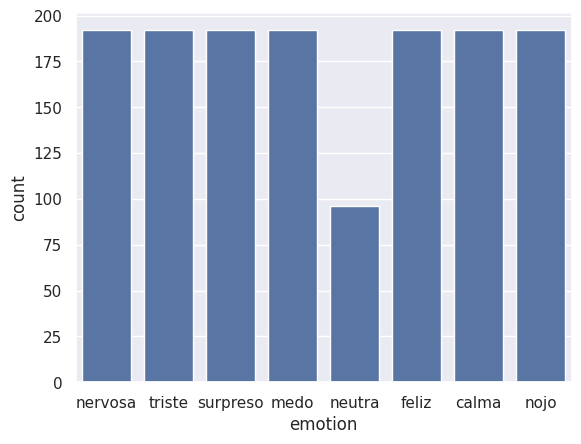

In [12]:
# Visualização gráfica
sns.countplot(df, x='emotion');

Canais: (182582,)
Número total de amostras: 182582
Arquivo:  /content/Audio_Speech_Actors/Actor_01/03-01-04-02-01-01-01.wav
Taxa de amostragem: 48000
Duração:  3.8037916666666667


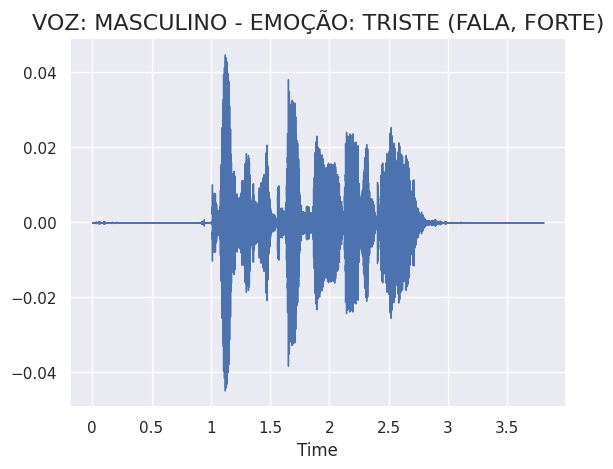

In [13]:
#Visualizando os dados de áudio

# Visualiza formas de onda e espectrogramas dos dados de áudio
n_files = df.shape[0]
rnd = np.random.randint(0, n_files)

fname = df.path[rnd]
data, sample_rate = librosa.load(fname, sr=None)

print('Canais:', data.shape)
print('Número total de amostras:', data.shape[0])
print('Arquivo: ', fname)
print('Taxa de amostragem:', sample_rate)
print('Duração: ', len(data) / sample_rate)

info = df.iloc[rnd].values
title_txt = f'voz: {info[4]} - emoção: {info[0]} ({info[1]}, {info[3]})'
plt.title(title_txt.upper(), size=16)
ld.waveshow(data, sr=sample_rate)
Audio(data = data, rate = sample_rate)

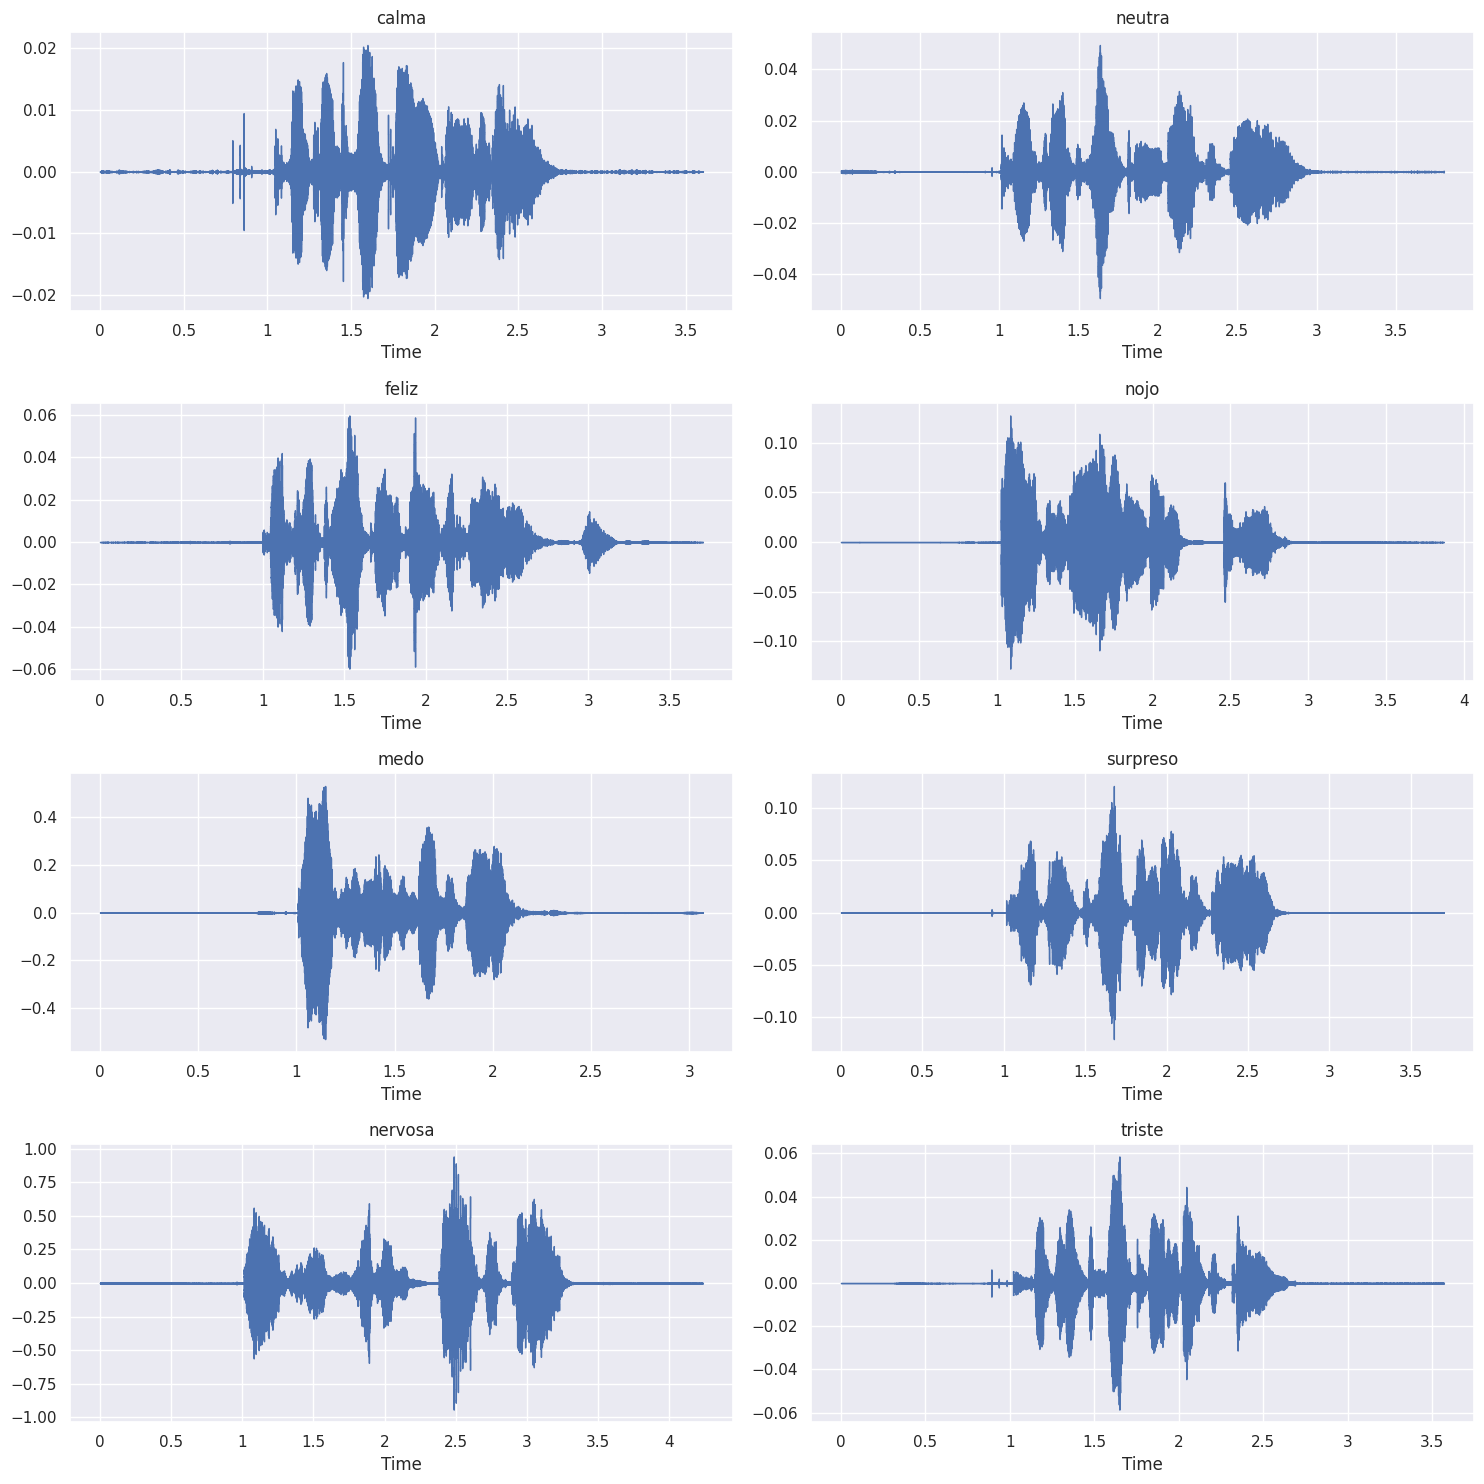

In [14]:
# Escolha aleatória de visualizações de formas de onda e espectrogramas de cada emoção
random_samples = df.groupby('emotion').sample(1)
audio_samples, labels = random_samples['path'].tolist(), random_samples['emotion'].tolist()

rows=4
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        librosa.display.waveshow(data, sr=sample_rate, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

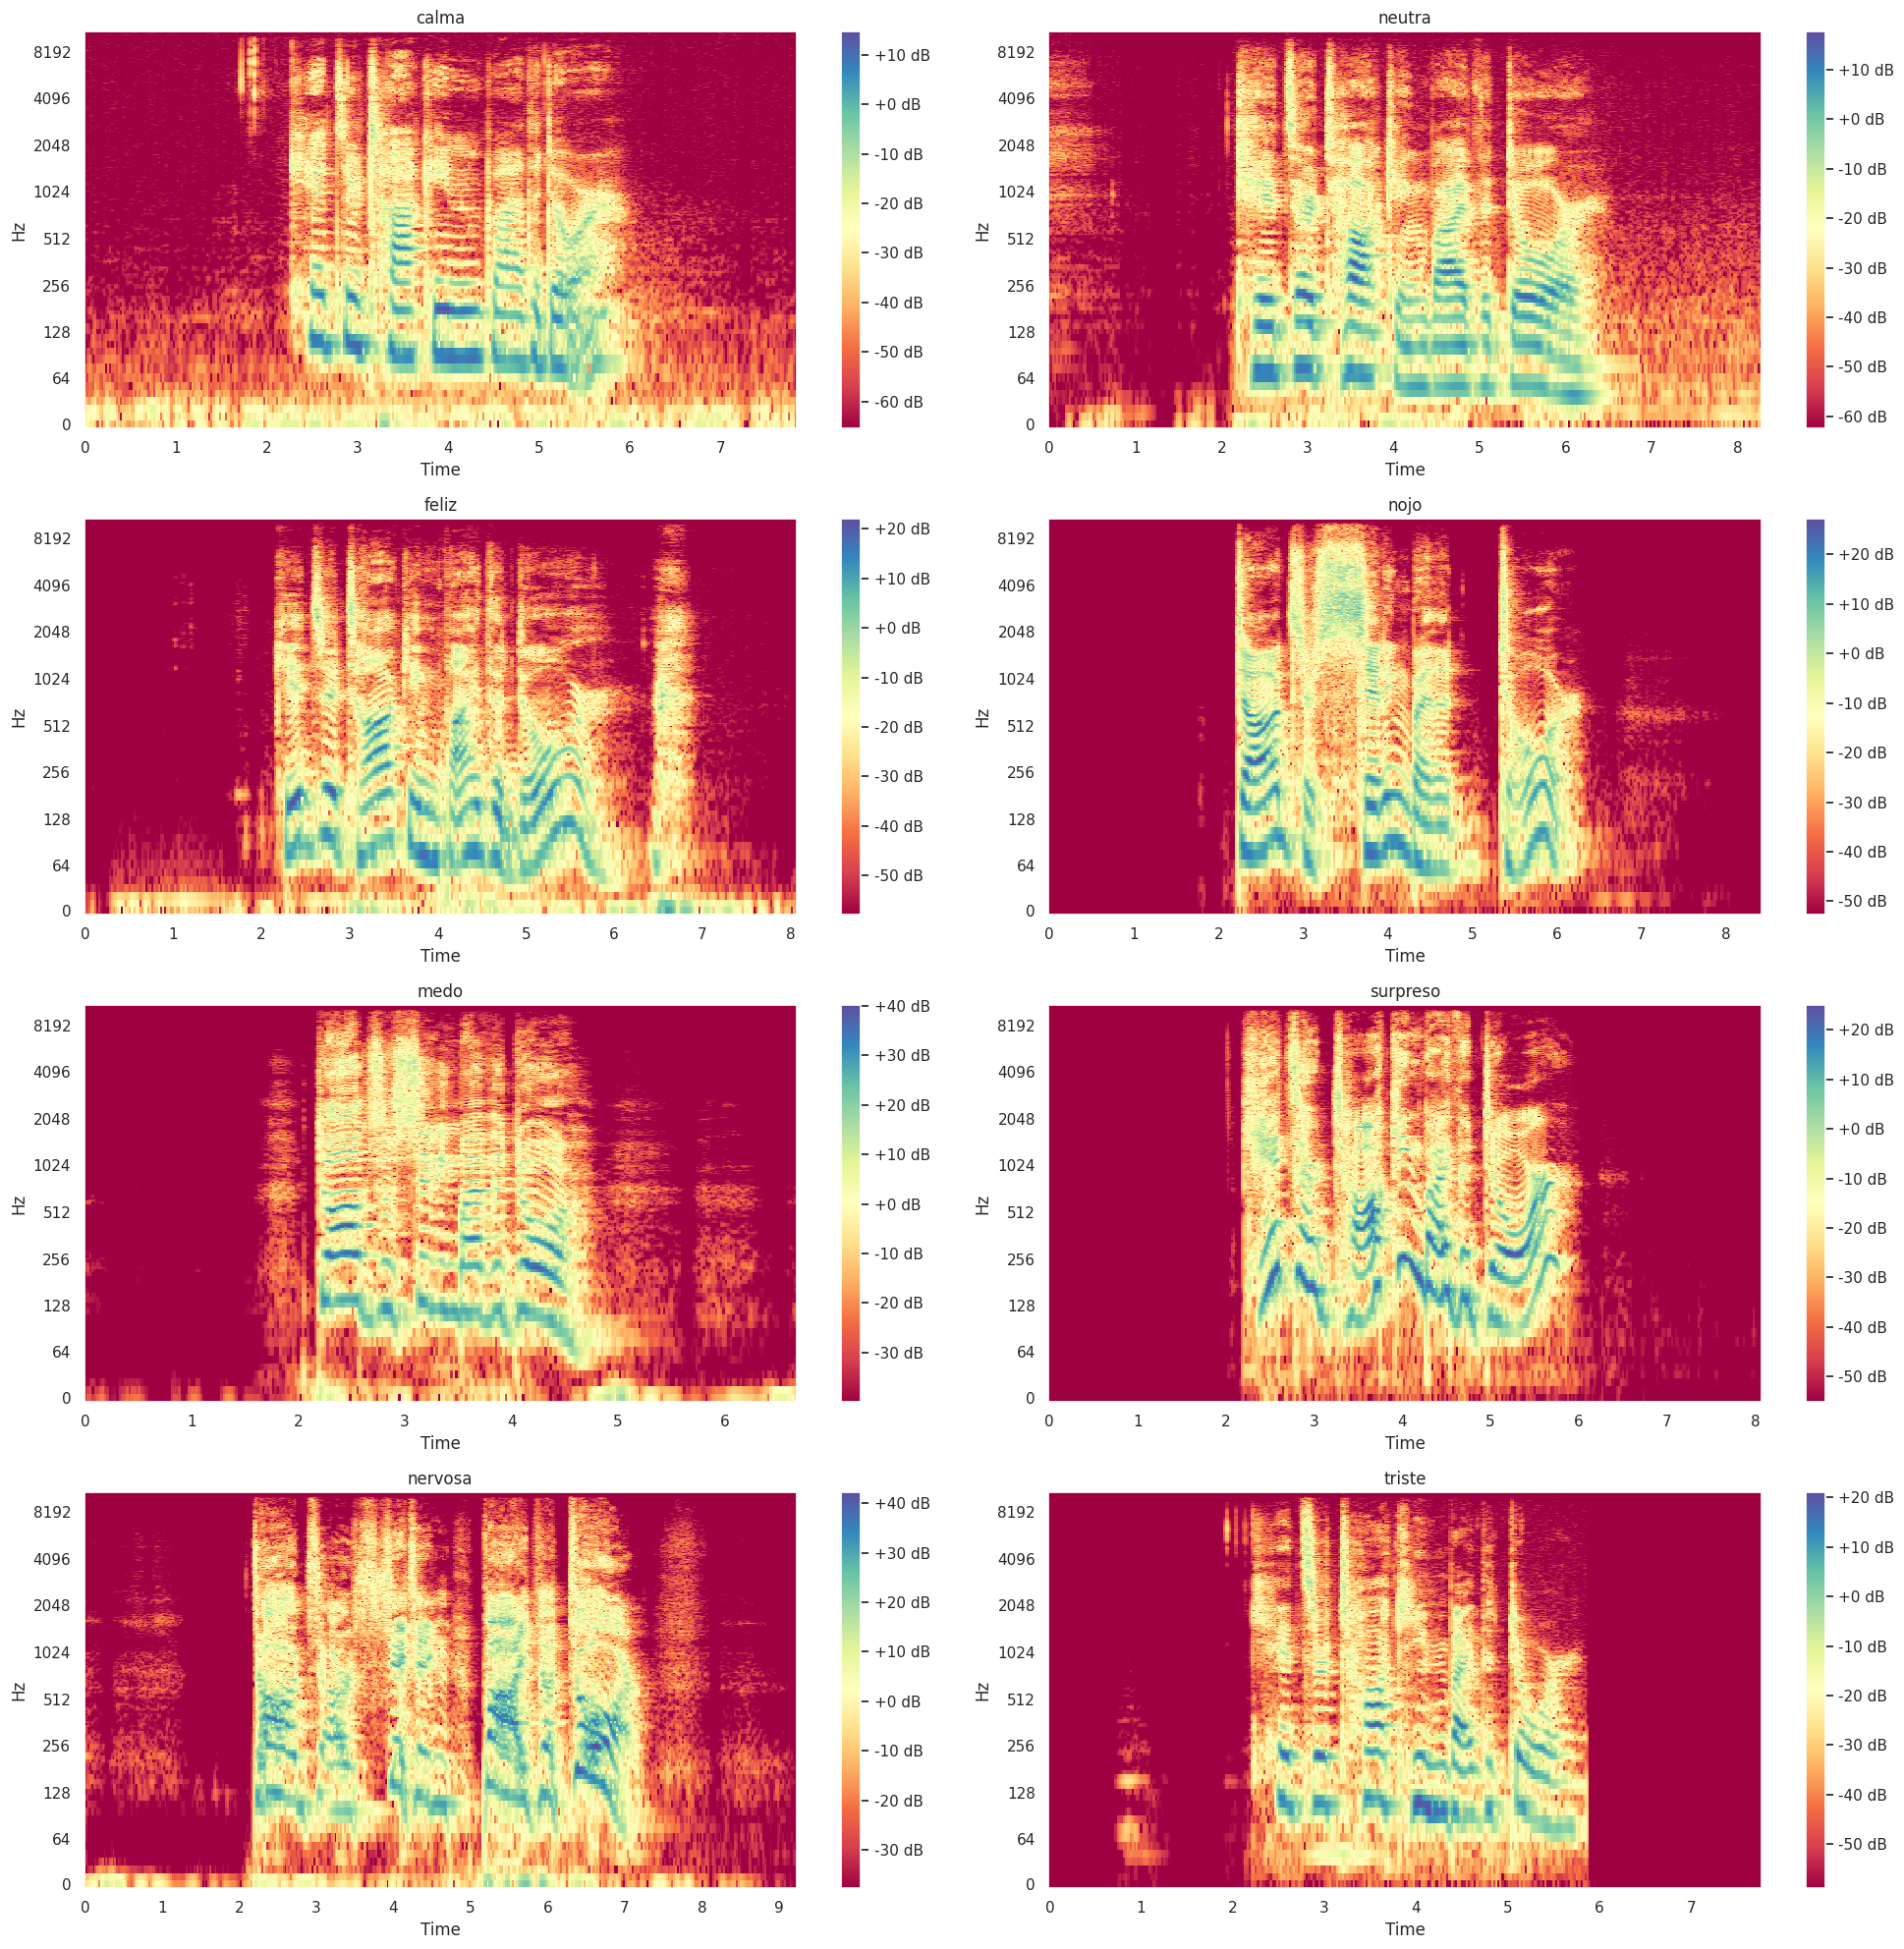

In [15]:
#Espectrogramas de STFT

# Cria o espectrograma para cada uma das emoções
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        stft = librosa.stft(y = data)
        stft_db = librosa.amplitude_to_db(np.abs(stft))
        img = librosa.display.specshow(stft_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1
fig.tight_layout()

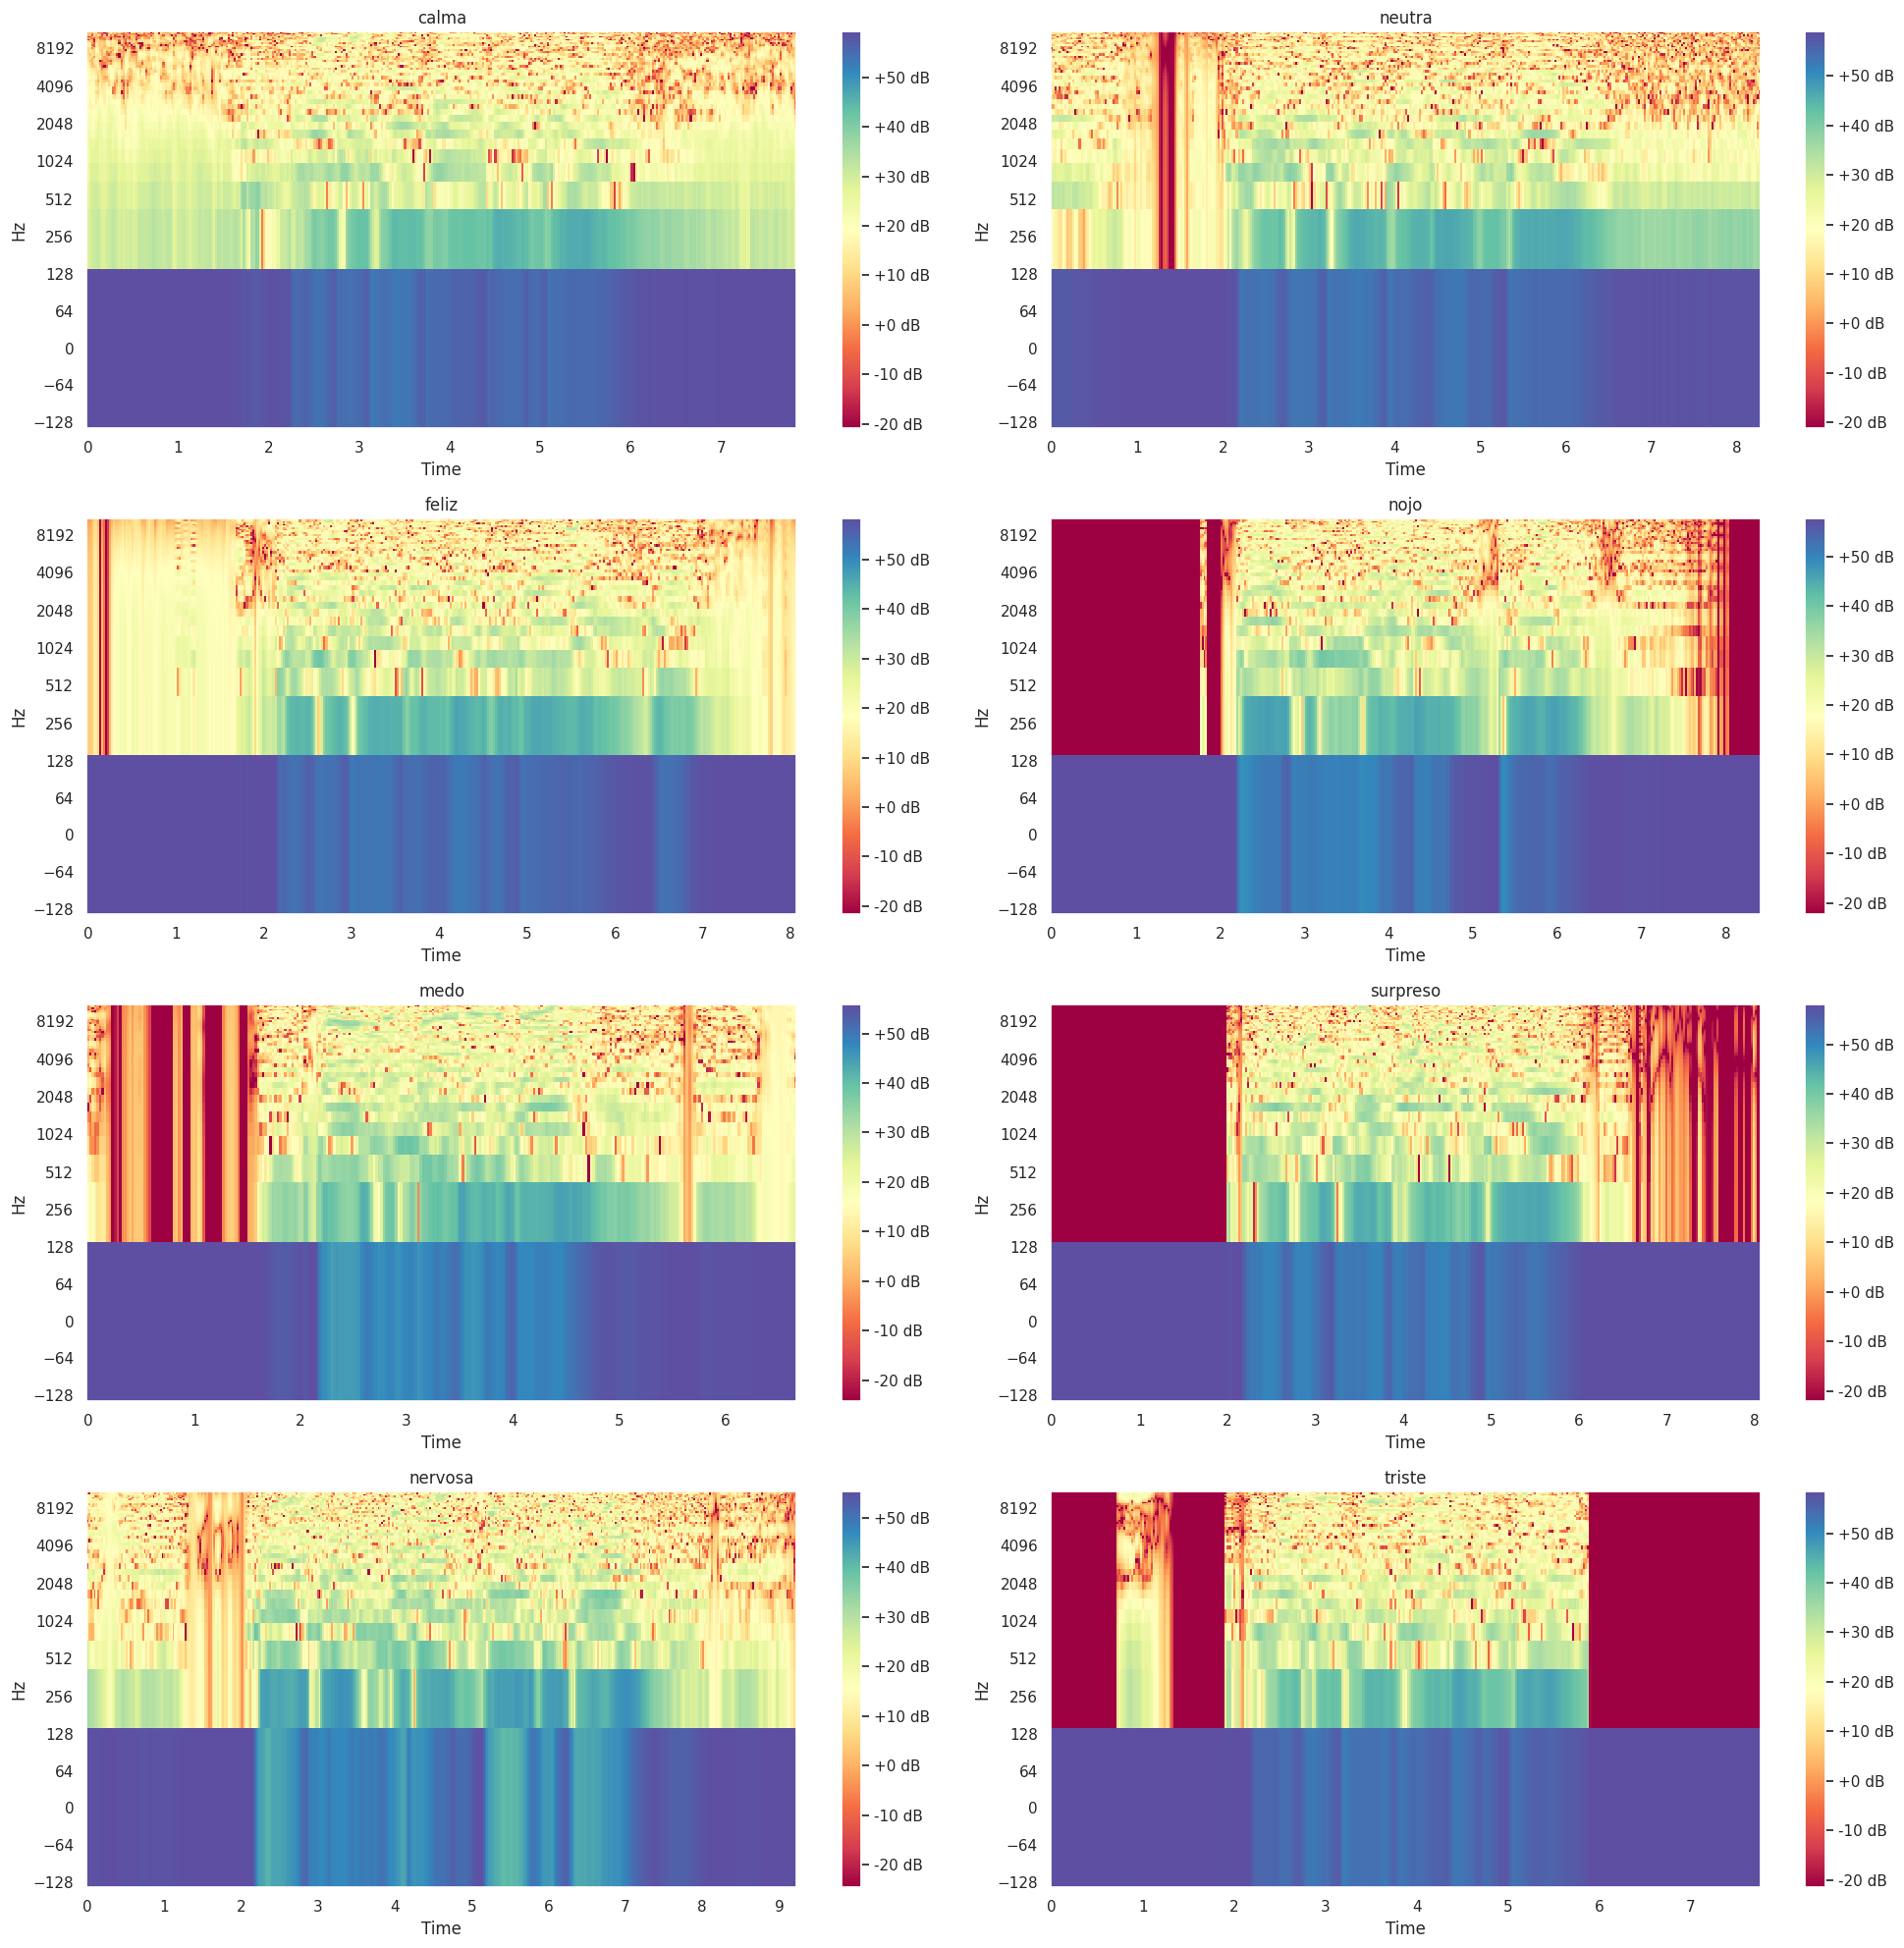

In [16]:
#Espectrogramas de MFCCs

fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
        img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1

fig.tight_layout()

In [17]:
#Pré-processamento

#Extraindo recursos/características MFCC's de cada arquivo de áudio do dataset
# Extrai características MFCC
def features_extractor(file_name):
    data, sample_rate = librosa.load(file_name, sr = None, res_type = 'kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
    return mfccs_scaled_features

extracted_features=[]
for path in tqdm(df.path.values):
  data = features_extractor(path)
  extracted_features.append([data])

100%|██████████| 1440/1440 [00:43<00:00, 33.09it/s]


In [18]:
#Convertendo os recursos extraídos para visualização com Pandas

# Converte os recursos extraídos em DataFrame para visualização
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature'])

In [19]:
#Dividindo entre atributos classe(class) e atributos previsores(features)

# Divide os dados em atributos de classe e atributos previsores
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(df.emotion.tolist())

# Cria um objeto para converter rótulos categóricos em valores numéricos
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

# Classes identificadas
labelencoder.classes_

# Divide os dados em conjuntos de treinamento e teste.
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Adiciona uma nova dimensão aos dados de treinamento e teste.
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

# Quantidade de classes de emoções
num_labels = y.shape[1]
num_labels

8

Criando o modelo
Criação da estrutura da rede neural

Os espectrogramas extraídos dos arquivos de áudio são como imagens 2D, então podemos usar técnicas de classificação de imagens neles, especificamente Redes Neurais Convolucionais (CNN)!

A arquitetura desta rede neural foi definida com base em alguns testes realizados para obter o resultado esperado. A estrutura pode ser ajustada livremente e comparada aos resultados desta estrutura.

Parâmetros:
Sequential, é a classe para criar a rede neural, pois uma rede neural nada mais é que uma sequência de camadas (camada e entrada, camadas ocultas, camada de saída);
kernel_size, o tamanho do kernel (matriz) de convolução;
activation, função de ativação;
input_shape, na primeira camada este é o tamanho dos dados de entrada
Camada MaxPooling1D, que vai fazer a extração das características principais;
Camada Conv1d, uma rede neural convolucional que realiza a convolução ao longo de apenas uma dimensão;
Camada Flatten, para transformar de matriz em vetor;
Camada Dense, quando um neurônio de uma camada está ligado a todas os outros neurônios das outras camadas;
Dropout, técnica de regularização para diminuir o overfitting;
padding='same', indica que adicionamos uma nova coluna composta por somente 0 (zeros) e utilizamos toda a imagem;

In [20]:
# Cria o modelo de rede neural
model=Sequential()

model.add(Conv1D(64, kernel_size=(5), activation='relu',input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(256, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 64)            384       
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 128)           41088     
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 128)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 256)            164096    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 256)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 1, 256)            0

Treinando o modelo
num_epochs, número de épocas de treinamento
num_batch_size, isto indica que vamos enviar de 32 em 32 recursos de áudio (32, 64, 96, 128,...8732)
ModelCheckpoint, para salvar o modelo enquanto faz o treinamento

filepath, caminho onde será salvo o modelo. Para isto temos uma pasta no Drive chamada saved_models
verbose, mostrar mensagens enquanto a rede neural é treinada
save_best_only = True, para salvar o modelo somente quando houver uma melhora no resultado
Variáveis para efetuar a contagem do tempo de treinamento:

start, pegando o horário atual de início do treinamento;
duration, ao final do treinamento, subtrair a hora atual com hora de início do treinamento.
model_history para armazenar o histórico de treinamento:

model.fit para fazer o ajuste do pesos ao longo do treinamento
X_train, Y_train, dados de treinamento
batch_size = num_batch_size que definimos acima
epochs = num_epochs que também definimos acima
validation_data=(X_test, Y_test), dados de teste para monitorarmos como está o percentual de acerto da rede neural a cada época
callbacks=[checkpointer], checkpointer definido anteriormente
verbose = 1, para mostrar as mensagens

In [21]:
# Montagem do Google Drive para acessar arquivos armazenados
from google.colab import drive
drive.mount('/content/gdrive')

# Realize o dowload da pasta Material_complementar_reconhecimento_voz.zip do Google Sala de Aula e transfira-a para o seu Google Drive
# Localize o caminho da pasta no menu Arquivos, no menu lateral esquerdo
import zipfile
#path = "/content/gdrive/MyDrive/Material_complementar_reconhecimento_voz.zip"
#zip_object = zipfile.ZipFile(file=path, mode="r")
#zip_object.extractall("./")

Mounted at /content/gdrive


In [22]:
# Treina o modelo conforme o modelo já treinado disponível na pasta modelos do Material_complementar_reconhecimento_voz.zip
num_epochs = 50
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='/content/modelos/speech_emotion_recognition.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()
model_history = model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs,
                          validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("[INFO] treinamento concluído em: ", duration)

Epoch 1/50
17/18 [===========================>..] - ETA: 0s - loss: 4.5905 - accuracy: 0.1360
Epoch 1: val_loss improved from inf to 2.04247, saving model to /content/modelos/speech_emotion_recognition.hdf5
18/18 [==============================] - 3s 68ms/step - loss: 4.4674 - accuracy: 0.1398 - val_loss: 2.0425 - val_accuracy: 0.1979
Epoch 2/50
 3/18 [====>.........................] - ETA: 0s - loss: 2.2229 - accuracy: 0.2083

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - ETA: 0s - loss: 2.1223 - accuracy: 0.1866
Epoch 2: val_loss did not improve from 2.04247
18/18 [==============================] - 1s 47ms/step - loss: 2.1223 - accuracy: 0.1866 - val_loss: 2.0546 - val_accuracy: 0.1597
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 2.0330 - accuracy: 0.1838
Epoch 3: val_loss improved from 2.04247 to 1.93022, saving model to /content/modelos/speech_emotion_recognition.hdf5
18/18 [==============================] - 1s 47ms/step - loss: 2.0292 - accuracy: 0.1866 - val_loss: 1.9302 - val_accuracy: 0.3021
Epoch 4/50
17/18 [===========================>..] - ETA: 0s - loss: 1.9865 - accuracy: 0.2031
Epoch 4: val_loss improved from 1.93022 to 1.90280, saving model to /content/modelos/speech_emotion_recognition.hdf5
18/18 [==============================] - 1s 48ms/step - loss: 1.9850 - accuracy: 0.2023 - val_loss: 1.9028 - val_accuracy: 0.2708
Epoch 5/50
17/18 [===========================>..] - ETA: 0

In [23]:
#Avaliando o modelo

# Avalia o desempenho do modelo treinado usando o conjunto de teste.
model.evaluate(X_test,Y_test, verbose=0)

# Imprime as chaves do dicionário 'history' que contém os registros do histórico de treinamento do modelo.
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


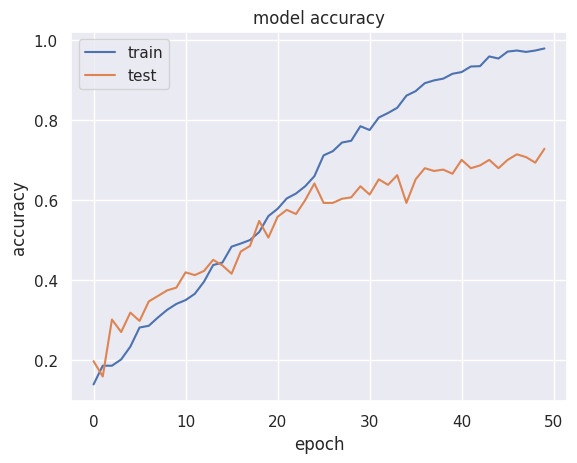

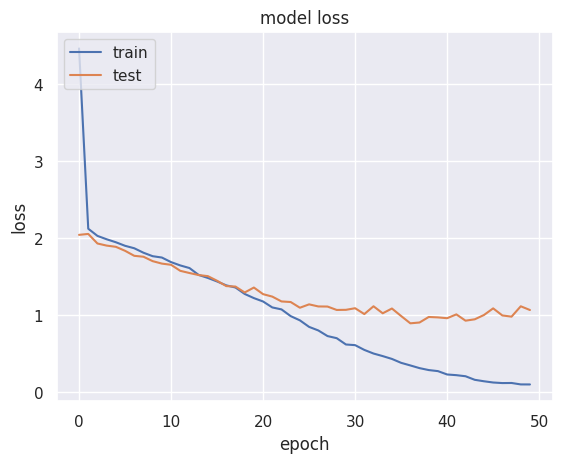

In [24]:
# Plota o gráfico da precisão (accuracy) e perda (loss) do modelo durante o treinamento e a validação.
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
#Comparando as classes reais com as classes previstas

# Compara classes reais com as previstas
predictions = model.predict(X_test)

# Converte as probabilidades das previsões em rótulos de classe. Cada previsão contém um conjunto de probabilidades para cada classe.
predictions = predictions.argmax(axis=1)

# Converte os índices de previsão em inteiros e os achata em um array unidimensional. Isso é necessário para processar as previsões.
predictions = predictions.astype(int).flatten()
predictions = (labelencoder.inverse_transform((predictions)))
predictions = pd.DataFrame({'Classes Previstas': predictions})
predictions



9/9 [==============================] - 1s 18ms/step


Classes Previstas
0             nervosa
1             nervosa
2             nervosa
3            surpreso
4                medo
..                ...
283             feliz
284            triste
285          surpreso
286          surpreso
287              nojo

[288 rows x 1 columns]

In [26]:
# Converte a matriz de rótulos de teste (Y_test) para obter o índice da classe com a maior probabilidade (classe real) para cada amostra.
actual = Y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (labelencoder.inverse_transform((actual)))
actual = pd.DataFrame({'Classes Reais': actual})
actual

Classes Reais
0         nervosa
1          triste
2         nervosa
3        surpreso
4          triste
..            ...
283         feliz
284        triste
285        triste
286      surpreso
287          nojo

[288 rows x 1 columns]

In [27]:
# Combina os DataFrames 'actual' e 'predictions' para criar um novo DataFrame chamado 'finaldf'.
finaldf = actual.join(predictions)
finaldf[140:150]

Classes Reais Classes Previstas
140        triste            triste
141         feliz             feliz
142         calma             calma
143          nojo              medo
144        neutra            neutra
145          medo              medo
146         calma             calma
147        triste             calma
148      surpreso          surpreso
149        triste             feliz

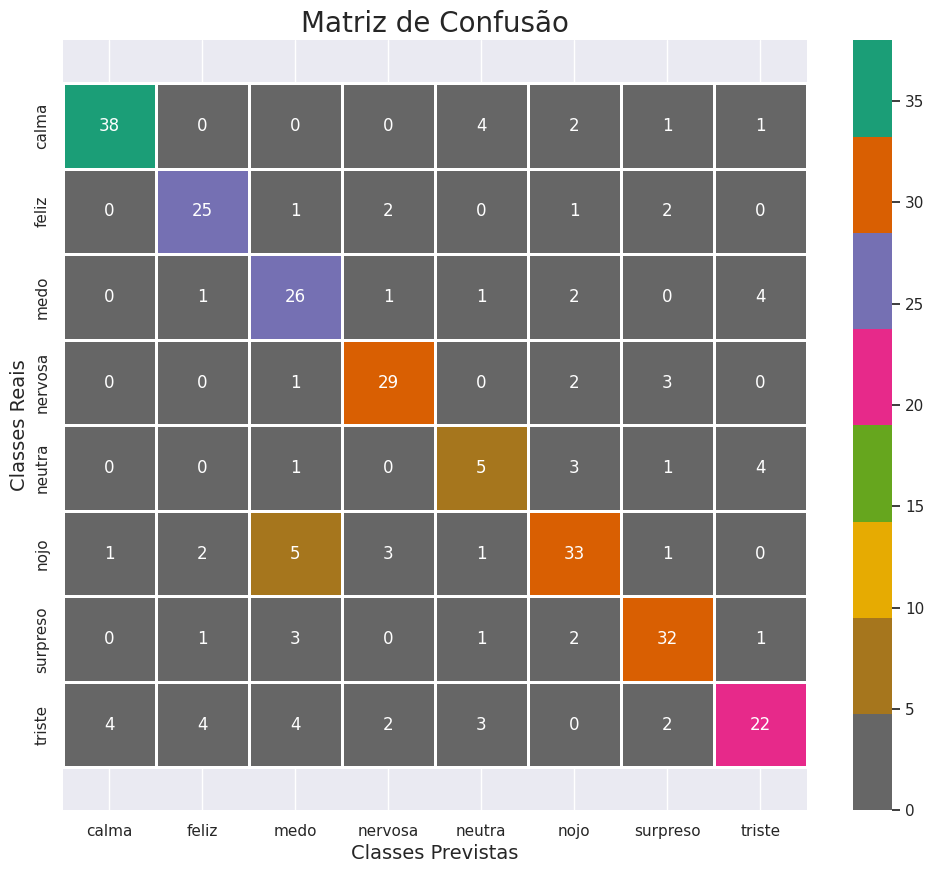

In [28]:
#Exibindo a Matriz de confusão

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in labelencoder.classes_] , columns = [i for i in labelencoder.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Dark2_r', linewidth=1, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de Confusão', size=20)
plt.xlabel('Classes Previstas', size=14)
plt.ylabel('Classes Reais', size=14)
plt.show()

In [29]:
#Visualizando a taxa e acerto para cada uma das classes

print(classification_report(actual, predictions))

              precision    recall  f1-score   support

       calma       0.88      0.83      0.85        46
       feliz       0.76      0.81      0.78        31
        medo       0.63      0.74      0.68        35
     nervosa       0.78      0.83      0.81        35
      neutra       0.33      0.36      0.34        14
        nojo       0.73      0.72      0.73        46
    surpreso       0.76      0.80      0.78        40
      triste       0.69      0.54      0.60        41

    accuracy                           0.73       288
   macro avg       0.70      0.70      0.70       288
weighted avg       0.73      0.73      0.73       288



In [30]:
#Testando o modelo em arquivos de áudio

def getInfo(data, sample_rate):
  print('Canais: ', data.shape)
  print('Número total de amostras: ', data.shape[0])
  print('Taxa de amostragem: ', sample_rate)
  print('Duração: ',  len(data) / sample_rate)

def predictSound(AUDIO, info = False, plot_waveform = False, plot_spectrogram = False):
  audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
  mfccs_scaled_features = mfccs_scaled_features[:,:,np.newaxis]
  predictions = model.predict(mfccs_scaled_features)
  plt.barh(labelencoder.classes_, predictions[0], color=list('rgbkymc'))
  predictions = predictions.argmax(axis=1)
  predictions = predictions.astype(int).flatten()
  predictions = (labelencoder.inverse_transform((predictions)))
  print('Resultado:', predictions)

  if info:
    getInfo(audio, sample_rate)

  if plot_waveform:
    plt.figure(figsize=(14,5))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    plt.xlabel("Tempo (segundos) ==>")
    plt.ylabel("Amplitude")
    ld.waveshow(audio, sr=sample_rate)

  if plot_spectrogram:
    plt.figure(figsize=(14,5))
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    ld.specshow(mfccs_db, x_axis="time", y_axis='log', cmap = 'Spectral')
    plt.colorbar(format='%+2.f dB')


AUDIO = "/content/Audio_Speech_Actors/Actor_02/03-01-01-01-01-01-02.wav" # Teste diferentes áudios
audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
Audio(data = audio, rate = sample_rate)

1/1 [==============================] - 0s 182ms/step
Resultado: ['nojo']
Canais:  (174574,)
Número total de amostras:  174574
Taxa de amostragem:  48000
Duração:  3.6369583333333333


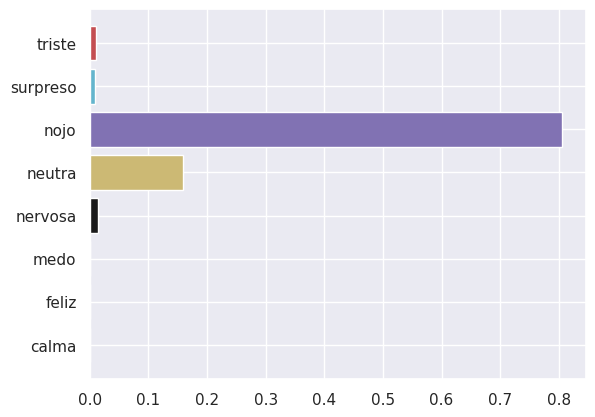

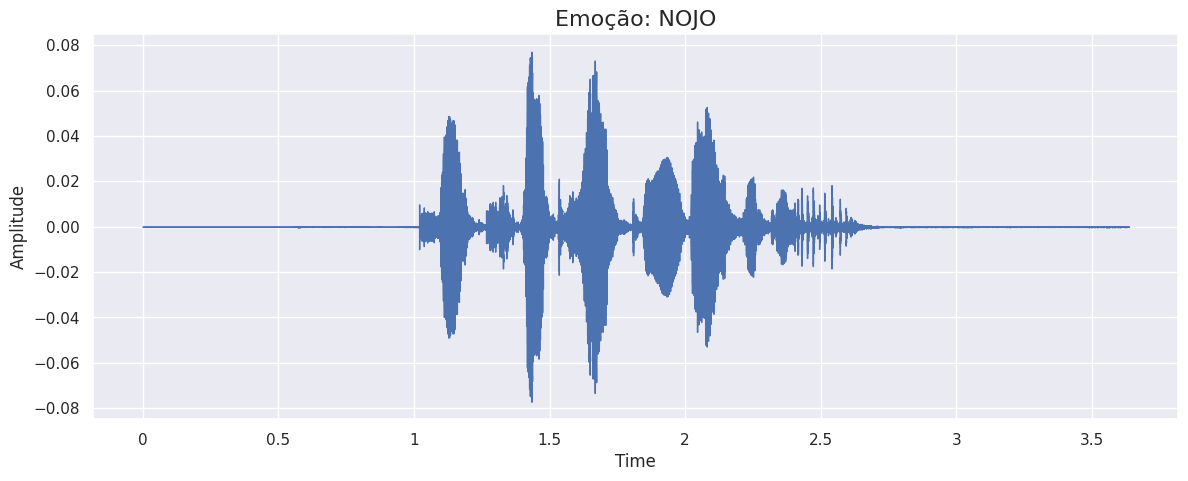

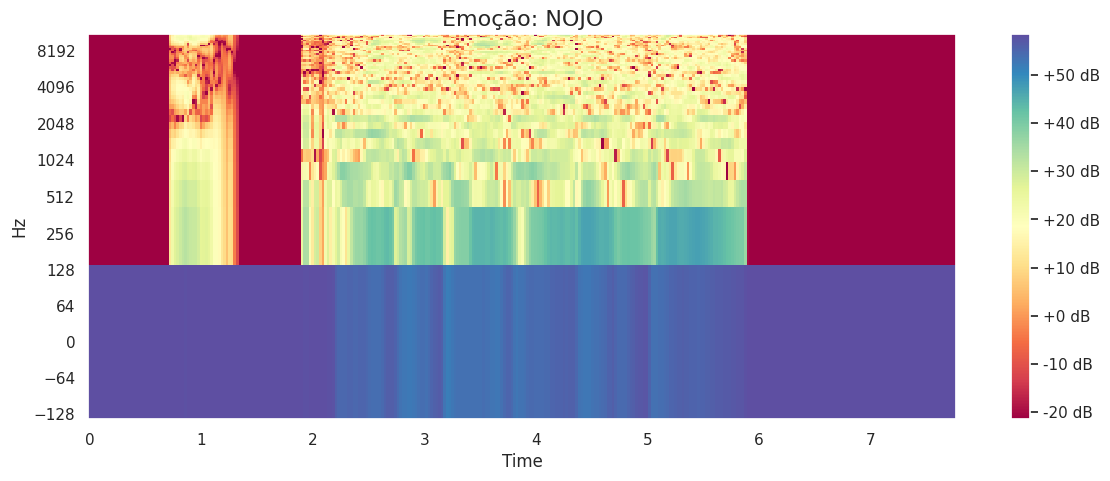

In [31]:
predictSound(AUDIO, info = True, plot_waveform = True, plot_spectrogram = True)